In [16]:
#Loading the dataset
import gzip
import pandas as pd
import os
# Create output directories
os.makedirs("results/python_qc", exist_ok=True)
df = pd.read_csv("/Users/bhaktithakkar/Downloads/GSE152075_raw_counts_GEO.txt.gz", sep=r"\s+", index_col = 0)

df.shape
display(df.iloc[:5,:5])

,POS_001,POS_002,POS_003,POS_004,POS_005
A1BG,0,1,0,0,18
A1CF,0,0,2,0,0
A2M,69,36,84,42,83
A2ML1,2,0,0,0,3
A2MP1,0,0,0,0,21


In [4]:
#Basic QC
print("Data shape (genes x samples):", df.shape)

print("\nMissing values:", df.isna().sum().sum())

print("\nSummary statistics:")
print(df.describe().T.head())

zero_genes = (df.sum(axis=1) ==0).sum()
print("\nGenes with all-zero counts:", zero_genes)

sample_sums = df.sum(axis = 0)
sample_sums.describe()

Data shape (genes x samples): (35784, 484)

Missing values: 0

Summary statistics:
           count        mean           std  min  25%  50%  75%        max
POS_001  35784.0   34.393304   2516.922298  0.0  0.0  0.0  1.0   326192.0
POS_002  35784.0   70.418623   5579.680637  0.0  0.0  0.0  4.0   952031.0
POS_003  35784.0   79.642997   7156.186432  0.0  0.0  0.0  4.0  1061860.0
POS_004  35784.0   59.549603   5548.197479  0.0  0.0  0.0  0.0   981854.0
POS_005  35784.0  124.241980  11169.491344  0.0  0.0  0.0  8.0  1998150.0

Genes with all-zero counts: 4272


count    4.840000e+02
mean     2.396611e+06
std      3.062674e+06
min      4.960610e+05
25%      9.932990e+05
50%      1.611844e+06
75%      2.645072e+06
max      3.559392e+07
dtype: float64

In [5]:
#Remove all the zero counts 
df_filtered = df.loc[(df.sum(axis=1) > 0)]
print("Filtered data shape:", df_filtered.shape)

#Remove lowly expressed genes
keep = (df_filtered > 1).sum(axis=1) >= 5
df_filtered = df_filtered.loc[keep]
print("Remaining genes:" , df_filtered.shape[0])

Filtered data shape: (31512, 484)
Remaining genes: 24699


In [6]:
#Normalisation and logarithm
import numpy as np
cpm = df_filtered.div(df_filtered.sum(axis=0), axis=1) * 1e6
log_cpm = np.log2(cpm +1)

print("Normalized matrix shape:", log_cpm.shape)
display(log_cpm.iloc[:5, :5])
                            

Normalized matrix shape: (24699, 484)


,POS_001,POS_002,POS_003,POS_004,POS_005
A1BG,0.000000,0.482251,0.000000,0.000000,2.336065
A1CF,0.000000,0.000000,0.767054,0.000000,0.000000
A2M,5.834575,3.934439,4.929566,4.372249,4.298033
A2ML1,1.392383,0.000000,0.000000,0.000000,0.744051
A2MP1,0.000000,0.000000,0.000000,0.000000,2.517051


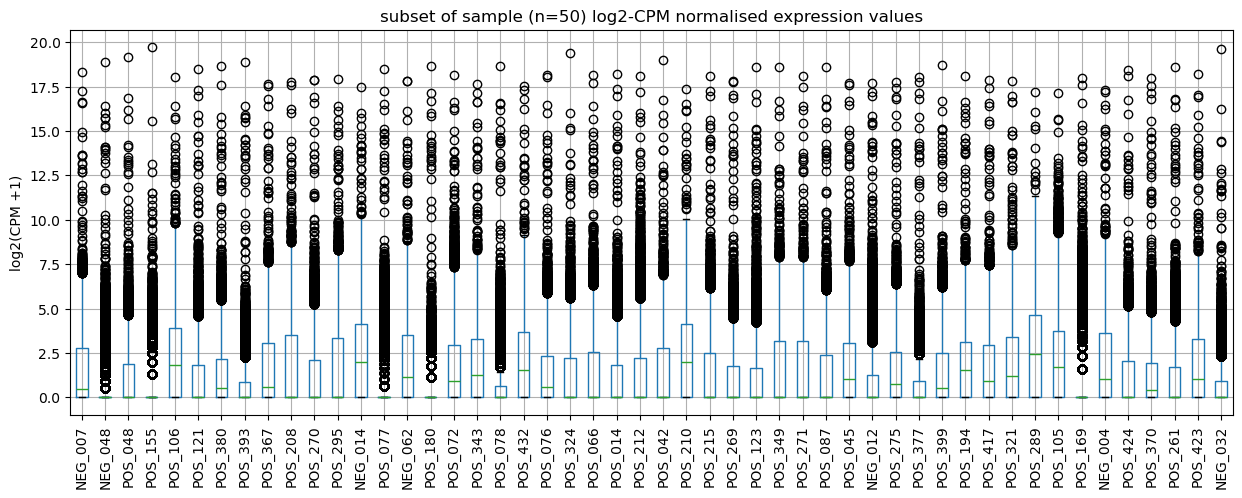

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
log_cpm.sample(50, axis=1).boxplot()
plt.title("subset of sample (n=50) log2-CPM normalised expression values")
plt.ylabel("log2(CPM +1)")
plt.xticks(rotation=90)
plt.show()

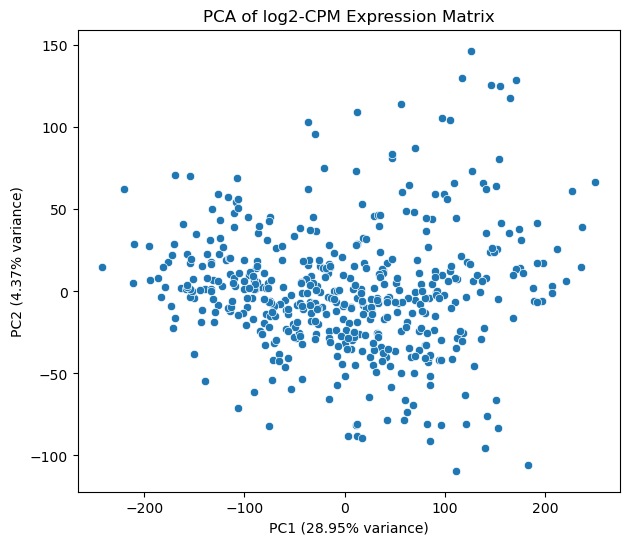

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

#PCA 

#Transform rows = samples, column = genes
X = log_cpm.T

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df.index = log_cpm.columns

plt.figure(figsize=(7,6))
sns.scatterplot(x='PC1', y = 'PC2', data=pca_df)
plt.title("PCA of log2-CPM Expression Matrix")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)")
plt.show()



<function matplotlib.pyplot.show(close=None, block=None)>

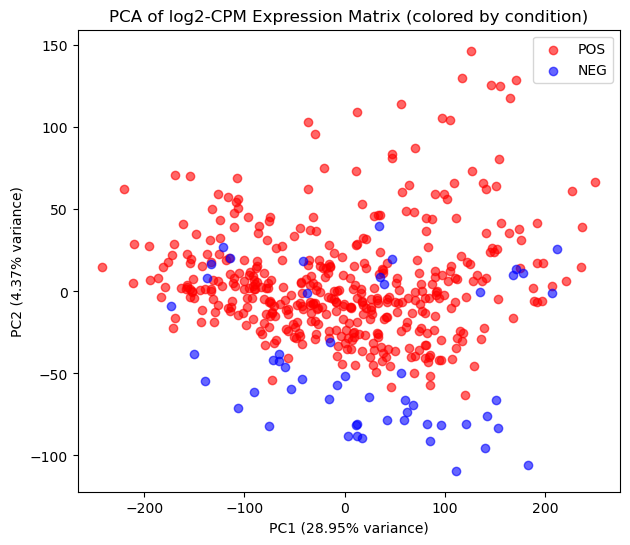

In [9]:
import matplotlib.pyplot as plt

condition = ['POS' if 'POS' in s else 'NEG' for s in log_cpm.columns]

plt.figure(figsize=(7,6))
for cond, color in [('POS' , 'red'), ('NEG' , 'blue')]:
    subset = [i for i, c in enumerate(condition) if c == cond]
    plt.scatter(pca_result[subset, 0], pca_result[subset, 1],
                label=cond, color=color, alpha=0.6)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)")
plt.title("PCA of log2-CPM Expression Matrix (colored by condition)")
plt.legend()
plt.show

In [10]:
#analyzing metadata

import gzip

meta_lines = []
path = "/Users/bhaktithakkar/Downloads/GSE152075_series_matrix.txt.gz"

with gzip.open(path, "rt", errors="ignore") as f:
    for line in f:
        if line.startswith("!Sample_characteristics_ch1"):
            meta_lines.append(line.strip())

len(meta_lines)

5

In [11]:
#Cleaning the metadata

import re

positivity = []
ct_values = []
ages = []
genders = []
batches = []

def extract_values(line):
    parts = line.split("\t")[1:]
    clean = []
    for p in parts:
        p = p.replace('"','').strip()
        if ":" in p:
            clean.append(p.split(":",1)[1].strip())
        else:
            clean.append(p)
    return clean
        
positivity = extract_values(meta_lines[0])
ct_values_raw = extract_values(meta_lines[1])
ages_raw = extract_values(meta_lines[2])
genders = extract_values(meta_lines[3])
batches = extract_values(meta_lines[4])

#convert ct values to numeric and unknown to nan
import numpy as np
ct_values = [float(x) if x.replace('.','',1).isdigit() else np.nan for x in ct_values_raw]

#convert ages to numeric
ages = []
for x in ages_raw:
    if x.isdigit():
        ages.append(int(x))
    elif x.startswith("90"):
        ages.append(90)
    else:
        ages.append(np.nan)

len(positivity), len(ct_values), len(ages), len(genders), len(batches)

print("positivity:", positivity[:10])
print("ct_values:", ct_values[:10])
print("ages:", ages[:10])
print("genders:", genders[:10])
print("batches:", batches[:10])



positivity: ['pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos']
ct_values: [18.88, 21.18, 24.24, 18.91, 25.62, 25.61, 21.8735, 25.91, 21.85, 17.99]
ages: [64, 30, 47, 67, 62, 52, 39, 59, 60, 71]
genders: ['M', 'F', 'M', 'F', 'M', 'F', 'M', 'F', 'F', 'M']
batches: ['I', 'I', 'I', 'G', 'H', 'H', 'G', 'I', 'I', 'I']


In [12]:
len(positivity), len(ct_values), len(ages), len(genders), len(batches)


(484, 484, 484, 484, 484)

In [13]:
#build a dataframe for metadata

import pandas as pd

samples = log_cpm.columns.tolist()

meta = pd.DataFrame({
    "sample" : samples,
    "positivity" : positivity,
    "ct_value" : ct_values,
    "age" : ages,
    "gender" : genders,
    "batch" : batches
})

#set sample names as index
meta.index = meta["sample"]
meta = meta.loc[samples]
meta = meta.drop(columns = ["sample"])
meta.head()

,positivity,ct_value,age,gender,batch
sample,,,,,
POS_001,pos,18.88,64.0,M,I
POS_002,pos,21.18,30.0,F,I
POS_003,pos,24.24,47.0,M,I
POS_004,pos,18.91,67.0,F,G
POS_005,pos,25.62,62.0,M,H


In [19]:
#PCA colored by positivity
import seaborn as sns
import matplotlib.pyplot as plt

pca_df = pd.DataFrame ({
    "PC1" : pca_result[:,0],
    "PC2" : pca_result[:,1],
    "positivity": meta["positivity"].values
})

plt.figure(figsize=(7,6))
sns.scatterplot(
    data=pca_df,
    x = "PC1", y = "PC2",
    hue = "positivity",
    palette = {"pos": "red", "neg": "blue"},
    alpha =  0.7
)

plt.title("PCA colored by positivity")
plt.savefig("results/python_qc/pca_by_positivity.png", dpi=300)
plt.close()

In [20]:
#PCA colored by batch 

pca_df["batch"] = meta["batch"].values

plt.figure(figsize=(7,6))
sns.scatterplot(
    data=pca_df,
    x = "PC1", y = "PC2",
    hue = "batch",
    palette = "tab20",
    alpha = 0.7
)

plt.title("PCA colored by batch")
plt.savefig("results/python_qc/pca_by_batch.png", dpi=300)
plt.close()
          

<function matplotlib.pyplot.show(close=None, block=None)>

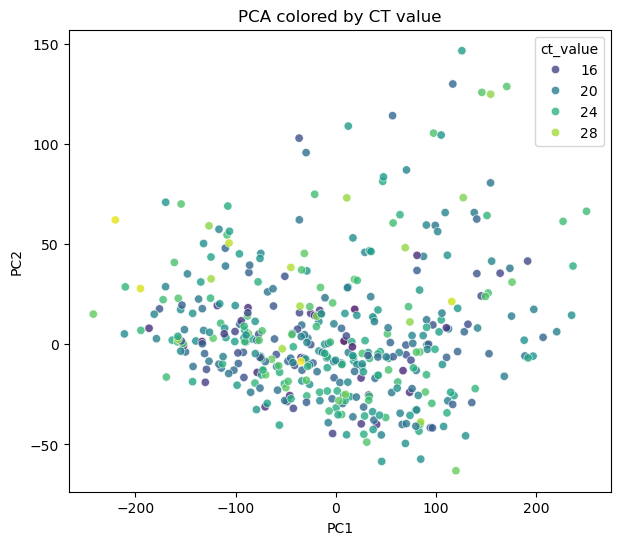

In [75]:
#PCA colored by CT value

pca_df["ct_value"] = meta["ct_value"].values

plt.figure(figsize = (7,6))
sns.scatterplot(
    data = pca_df,
    x = "PC1",  y = "PC2",
    hue = "ct_value",
    palette = "viridis",
    alpha = 0.8
)

plt.title("PCA colored by CT value")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

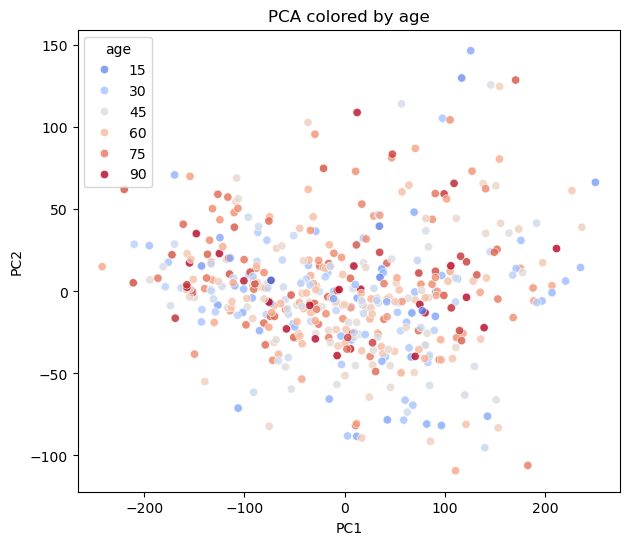

In [77]:
#PCA colored by age

pca_df["age"] = meta["age"].values

plt.figure(figsize = (7,6))
sns.scatterplot(
    data = pca_df,
    x = "PC1",  y = "PC2",
    hue = "age",
    palette = "coolwarm",
    alpha = 0.8
)

plt.title("PCA colored by age")
plt.show

In [80]:
#continue the work in r 
df_filtered.to_csv("counts_filtered.csv")
meta.to_csv("metadata.csv")
